# Variation Autoencoder for MNIST



In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [10]:
# ハイパーパラメータ
batch_size = 128
latent_dim = 2  # 中間層の次元
epochs = 50
learning_rate = 1e-3

# MNISTデータセットの読み込みとデータローダーの作成
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



In [11]:
# VAEモデルの定義
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*32, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 7*7*32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return z

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



Epoch 1, Loss: 54.9707
Epoch 2, Loss: 43.0682
Epoch 3, Loss: 41.1776
Epoch 4, Loss: 40.1304
Epoch 5, Loss: 39.4100
Epoch 6, Loss: 38.8609
Epoch 7, Loss: 38.4844
Epoch 8, Loss: 38.2118
Epoch 9, Loss: 37.9282
Epoch 10, Loss: 37.7552
Epoch 11, Loss: 37.5529
Epoch 12, Loss: 37.4054
Epoch 13, Loss: 37.2511
Epoch 14, Loss: 37.1149
Epoch 15, Loss: 36.9845
Epoch 16, Loss: 36.8942
Epoch 17, Loss: 36.7945
Epoch 18, Loss: 36.7257
Epoch 19, Loss: 36.6515
Epoch 20, Loss: 36.5583
Epoch 21, Loss: 36.4797
Epoch 22, Loss: 36.4185
Epoch 23, Loss: 36.3677
Epoch 24, Loss: 36.2680
Epoch 25, Loss: 36.2263
Epoch 26, Loss: 36.1904
Epoch 27, Loss: 36.1297
Epoch 28, Loss: 36.0734
Epoch 29, Loss: 36.0280
Epoch 30, Loss: 35.9506
Epoch 31, Loss: 35.9340
Epoch 32, Loss: 35.8508
Epoch 33, Loss: 35.8492
Epoch 34, Loss: 35.8050
Epoch 35, Loss: 35.7591
Epoch 36, Loss: 35.7320
Epoch 37, Loss: 35.6830
Epoch 38, Loss: 35.6772
Epoch 39, Loss: 35.6188
Epoch 40, Loss: 35.5754
Epoch 41, Loss: 35.5569
Epoch 42, Loss: 35.5317
E

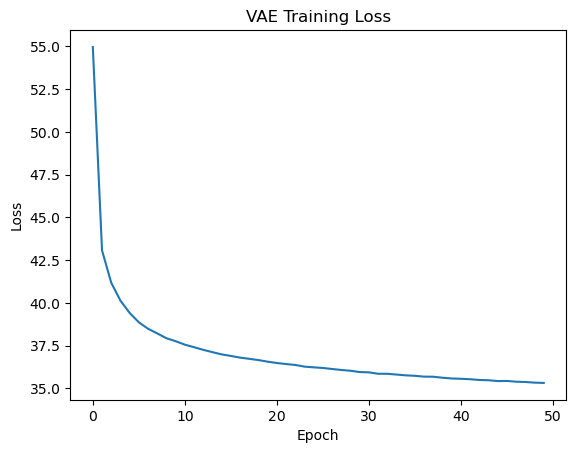

In [12]:
# モデル、損失関数、最適化手法の定義
model = VAE(latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar):
#    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    MSE = nn.functional.mse_loss(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# 学習ループ
train_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader.dataset))
    print(f'Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}')

# 学習曲線のプロット
plt.plot(train_losses)
plt.title('VAE Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



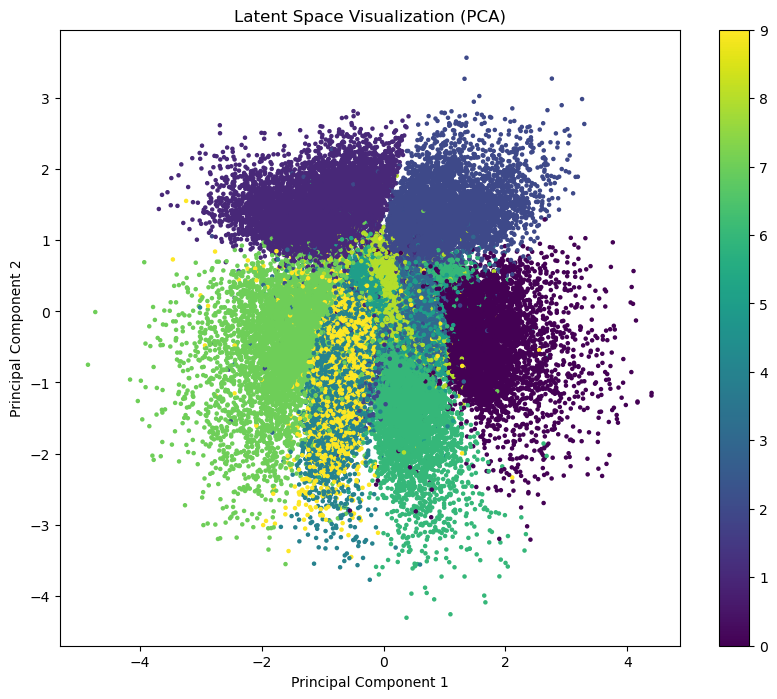

In [13]:
# 中間層の出力の可視化 (PCA適用)
model.eval()
z_list = []
labels_list = []
with torch.no_grad():
    for data, labels in train_loader:
        mu, logvar = model.encode(data)
        z = model.reparameterize(mu, logvar)
        z_list.extend(z.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())
z_list = np.array(z_list)
labels_list = np.array(labels_list)

pca = PCA(n_components=2)
z_pca = pca.fit_transform(z_list)

plt.figure(figsize=(10, 8))
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=labels_list, cmap='viridis', s=5)
plt.colorbar()
plt.title('Latent Space Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



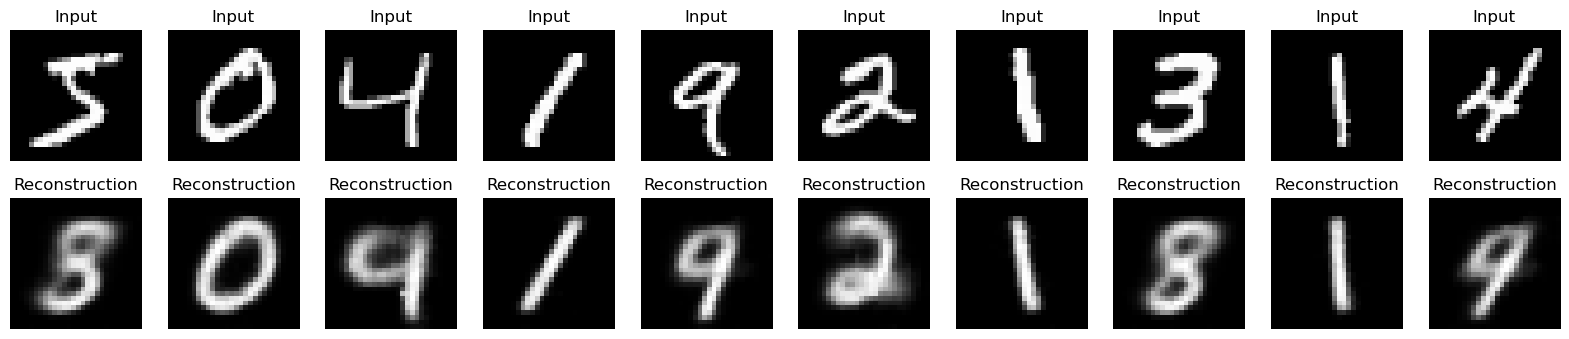

In [14]:
# 入力画像と再構成画像の比較
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    with torch.no_grad():
        sample = train_dataset[i][0].unsqueeze(0)
        recon_sample, _, _ = model(sample)
    plt.subplot(2, n, i+1)
    plt.imshow(sample.squeeze().numpy(), cmap='gray')
    plt.title('Input')
    plt.axis('off')
    plt.subplot(2, n, i+n+1)
    plt.imshow(recon_sample.squeeze().numpy(), cmap='gray')
    plt.title('Reconstruction')
    plt.axis('off')
plt.show()